In [ ]:
Предварительно был применен SQL для вывода данных из БД

-- MAU авторов

SELECT 
  main_author_name,
  COUNT(DISTINCT puid) AS mau
FROM bookmate.author aut
JOIN bookmate.content c USING(main_author_id)
JOIN bookmate.audition aud USING(main_content_id)
WHERE msk_business_dt_str >= DATE '2024-11-01'
  AND msk_business_dt_str < DATE '2024-12-01'
GROUP BY main_author_name
ORDER BY mau DESC
LIMIT 3;

-- MAU произведений

SELECT 
  main_content_name,
  published_topic_title_list,
  main_author_name,
  COUNT(DISTINCT puid) AS mau
FROM bookmate.author aut
JOIN bookmate.content c USING(main_author_id)
JOIN bookmate.audition aud USING(main_content_id)
WHERE msk_business_dt_str >= DATE '2024-11-01'
  AND msk_business_dt_str < DATE '2024-12-01'
GROUP BY 1, 2, 3
ORDER BY mau DESC
LIMIT 3;

-- Retention Rate

-- Новые пользователи — те, кто активен 2 декабря
WITH new_users AS (
    SELECT DISTINCT puid
    FROM bookmate.audition
    WHERE msk_business_dt_str = DATE '2024-12-02'
),

-- Все активности пользователей из этой когорты
active_users AS (
    SELECT
        a.puid,
        a.msk_business_dt_str::date AS log_date
    FROM bookmate.audition a
    JOIN new_users nu ON a.puid = nu.puid
    WHERE a.msk_business_dt_str::date >= DATE '2024-12-02'
),

-- Разница между датой события и датой установки
daily_retention AS (
    SELECT
        puid,
        (log_date - DATE '2024-12-02')::int AS day_since_install
    FROM active_users
)

-- Финальный расчёт retention
SELECT
    day_since_install,
    COUNT(DISTINCT puid) AS retained_users,
    ROUND(
        (1.0 * COUNT(DISTINCT puid) / MAX(COUNT(DISTINCT puid)) OVER (ORDER BY day_since_install))::numeric,
        2
    ) AS retention_rate
FROM daily_retention
WHERE day_since_install < 30
GROUP BY day_since_install
ORDER BY day_since_install;


--  LTV

WITH active_users AS (
    SELECT
        usage_geo_id_name AS city,
        puid,
        COUNT(DISTINCT EXTRACT(MONTH FROM msk_business_dt_str)) AS months_count
    FROM bookmate.audition AS ba
    JOIN bookmate.geo AS bg ON ba.usage_geo_id = bg.usage_geo_id
    GROUP BY city, puid
),
total_months AS (
    SELECT
        city,
        puid,
        SUM(months_count) AS total_months_count
    FROM active_users
    WHERE city IN ('Москва', 'Санкт-Петербург')
    GROUP BY city, puid
)
SELECT
    city,
    COUNT(DISTINCT puid) AS total_users,
    ROUND((399::numeric * SUM(total_months_count) / COUNT(DISTINCT puid)), 2) AS ltv
FROM
    total_months
WHERE
    city IN ('Москва', 'Санкт-Петербург')
GROUP BY city
ORDER BY city;

-- Расчёт средней выручки прослушанного часа — аналог среднего чека

WITH monthly_summary AS (
SELECT
DATE_TRUNC('month', CAST(msk_business_dt_str AS DATE))::DATE AS month,
COUNT(DISTINCT puid) AS mau,
SUM(hours) AS hours
FROM bookmate.audition
WHERE msk_business_dt_str >= '2024-09-01'
AND msk_business_dt_str < '2024-12-01'
GROUP BY DATE_TRUNC('month', CAST(msk_business_dt_str AS DATE))
)
SELECT
month,
mau,
ROUND(hours, 2) AS hours,
ROUND((mau * 399) / hours, 2) AS avg_hour_rev
FROM monthly_summary;



# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Москвы проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Анализ данных Яндекс.Книги

- Автор: Надежда Поверенова
- Дата: 27.03.2025

## Цели и задачи проекта

Задача 1 части проекта - загрузить данные, ознакомиться с ними и с помощью статистических тестов проверить гипотезу о том, что в Санкт-Петербурге пользователи больше времени проводят за чтением и прослушиванием книг, чем в Москве. 

## Описание данных

ab_test_participants.csv — таблица участников тестов.

**Структура файла:**
- user_id — идентификатор пользователя;
- group — группа пользователя;
- ab_test — название теста;
- device — устройство, с которого происходила регистрация.

ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года;

**Структура файла:**
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии.

## Содержимое проекта


1. Загрузка и знакомство с данными
2. Проверка гипотезы о пользователях из Санкт-Петербурга
3. Подготовка аналитической записки о результатах теста

---

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Импортируем библиотеки
import pandas as pd
import warnings
from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Общие настройки блокнота
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Настройки для повышения читаемости
pd.set_option('display.expand_frame_repr', False)

# Общие настройки для графиков
large = 16
med = 12
small = 10

params = {
    "axes.titlesize": large,
    "legend.fontsize": med,
    "figure.figsize": (12, 8),
    "axes.labelsize": med,
    "axes.titlesize": med,
    "xtick.labelsize": med,
    "ytick.labelsize": med,
    "figure.titlesize": large,
}

plt.rcParams.update(params)

# Получаем цвета из палитры Seaborn
palette = sns.color_palette("viridis")

# Устанавливаем цвета для всех графиков Matplotlib
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette)

warnings.filterwarnings("ignore")

In [3]:
# Загружаем данные в датасет
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [4]:
# Фильтруем пользователей по городам
m_hours = df[df['city'] == 'Москва']['hours']
spb_hours = df[df['city'] == 'Санкт-Петербург']['hours']

# Проверяем нормальность распределения
display(stats.shapiro(m_hours))
display(stats.shapiro(spb_hours))

# Проверяем равенство дисперсий 
display(stats.levene(m_hours, spb_hours))

ShapiroResult(statistic=0.29297834634780884, pvalue=0.0)

ShapiroResult(statistic=0.28286635875701904, pvalue=0.0)

LeveneResult(statistic=0.60611624217368, pvalue=0.4362748478542563)

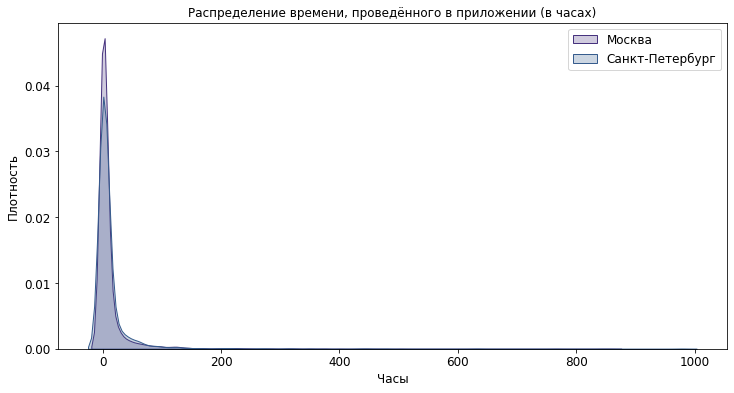

In [5]:
# Строим графики распределения 
plt.figure(figsize=(12, 6))

# Построим распределения
sns.kdeplot(data=df[df['city'] == 'Москва'], x='hours', label='Москва', shade=True)
sns.kdeplot(data=df[df['city'] == 'Санкт-Петербург'], x='hours', label='Санкт-Петербург', shade=True)

# Добавим подписи
plt.title('Распределение времени, проведённого в приложении (в часах)')
plt.xlabel('Часы')
plt.ylabel('Плотность')
plt.legend()

# Показать график
plt.show()

Распределение ассиметрично с резким смещением влево, с длинным хвостом. Кривые при этом почти совпадают, то есть распределения Москвы и Санкт-Петербурга очень похожи. Данные не нормально распределены, но выборка достаточно большая.

Дисперсии двух выборок похожи.

In [6]:

# Проводим односторонний t-тест
t_stat, p_value = mannwhitneyu(spb_hours, m_hours, alternative='greater')

display('Mann–Whitney U test')
display("p-value:", p_value)

# Интерпретация
alpha = 0.05
if p_value < alpha:
    display('Отвергаем нулевую гипотезу. В СПб пользователи проводят в среднем больше времени.')
else: 
    display('Нулевая гипотеза подтверждается.')

'Mann–Whitney U test'

'p-value:'

0.08905943967440888

'Нулевая гипотеза подтверждается.'

**По итогам** проверки исходных данных можно сказать следующее:
- Распределение данных не нормальное, со смещением влево, имеет длинный хвост.
- При применении одностороннего теста Манна-Уитни бОльшая активность пользователей в Санкт-Петербурге **не была подтверждена**.

## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



**Результаты исследования:**
- Для проверки гипотезы был выбран непараметрический односторонний тест Манна-Уитни из-за ненормальности распределения (по тесту Шапиро-Уилка). Уровень статистической значимости был установлен в размере 5%.
- В результате проведения теста  был получен p-value 0.089, что больше уровня значимости, то есть нулевая гипотеза не отвергается.
- На основании теста *нельзя утверждать*, что пользователи из Санкт-Петербурга проводят больше времени в приложении, чем пользователи из Москвы. 
- **Возможные причины:**
  - Высокая вариативность данных - распределения имеют длинный хвост, что может размывать отличие между группами.
  - Возможно, в среднем пользователи в Москва и Санкт-Петербурге проводят примерно одинаковое количество времени за чтением и прослушиванием книг, то есть различие незначительное.


----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Исследование данных проводится с целью оценки результатов А/В теста, в котором проверялась новая версия сайта. Будет проведена загрузка данных, оценка корректности проведения теста и оценка результатов тестирования.

## 2. Загрузите данные, оцените их целостность.


In [7]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

Предыдущий аналитик проверял полное обновление дизайна сайта. Гипотеза заключается в следующем: упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.

In [8]:
# Отфильтруем только необходимый нам тест
participants = participants[participants['ab_test'] == 'interface_eu_test'].copy()
# Проверяем количество уникальных пользователей
a_grp = participants[participants['group'] == 'A']['user_id'].nunique()
b_grp = participants[participants['group'] == 'B']['user_id'].nunique()
print(f"""
Количество пользователей в группе А: {a_grp}
Количество пользователей в группе В: {b_grp}
""")



Количество пользователей в группе А: 5383
Количество пользователей в группе В: 5467



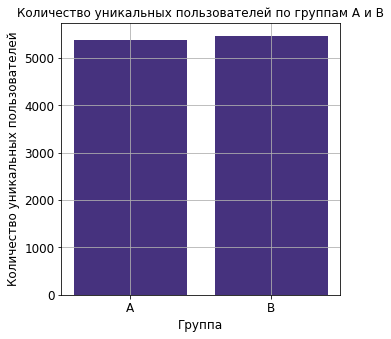

In [9]:
# Создаем визуализацию
plt.figure(figsize=(5,5))
plt.bar(['A', 'B'], [a_grp, b_grp])
plt.title('Количество уникальных пользователей по группам A и B')
plt.xlabel("Группа")
plt.ylabel("Количество уникальных пользователей")
plt.grid(True)
plt.show()

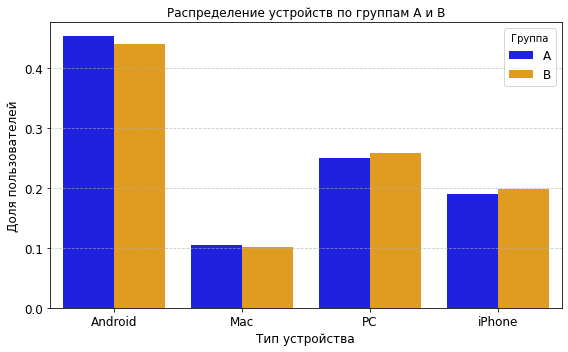

In [10]:
# Считаем доли устройств в каждой группе
share_grp = participants.groupby(['device','group'])['user_id'].nunique().reset_index()
share_grp.columns = ['device', 'group', 'quantity']
total_per_group = share_grp.groupby('group')['quantity'].transform('sum')
share_grp['share'] = share_grp['quantity'] / total_per_group

# Строим график
plt.figure(figsize=(8, 5))
sns.barplot(data=share_grp, x='device', y='share', hue='group', palette=['blue', 'orange'])

# Оформление
plt.title('Распределение устройств по группам A и B')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Группа')
plt.tight_layout()
plt.show()

In [11]:
# Проверка пересечений пользователей
grp_a_list = set(participants[participants['group']=='A']['user_id'])
grp_b_list = set(participants[participants['group']=='B']['user_id'])

# Проверка на пересечение пользователей между группами
common_users = grp_a_list.intersection(grp_b_list)
if common_users:
    print(f"Количество пользователей, которые встречаются в обеих группах: {len(common_users)}")
else:
    print("Нет пользователей, которые встречаются в обеих группах.")

Нет пользователей, которые встречаются в обеих группах.


**Итого:**
- После проверки не было выявлено пользователей, участвующих в тесте.
- Распределение пользователей между группами достаточно равномерно.
- Данные соответствуют техническому заданию.

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [12]:
# Фильтруем пользователей, участвующих в тесте
print(f"До фильтрации в датафрейме events было пользователей: {events['user_id'].nunique()}")
events_f = events[events['user_id'].isin(participants['user_id'])]
print(f"После фильтрации в датафрейме events стало пользователей: {events_f['user_id'].nunique()}")

До фильтрации в датафрейме events было пользователей: 144184
После фильтрации в датафрейме events стало пользователей: 10850


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [13]:
# Найдем дату регистрации каждого пользователя
registration = events_f[events_f['event_name'] == 'registration'].groupby('user_id')['event_dt'].min().reset_index()
registration = registration.rename(columns={'event_dt':'registration_dt'})

# Объединяем датафреймы
events_f = events_f.merge(registration, on='user_id', how='left')

# Считаем лайфтайм события
events_f['lifetime'] = (events_f['event_dt'] - events_f['registration_dt']).dt.days

# Фильтруем события
events_f_7d = events_f[events_f['lifetime'] < 7]

Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [14]:
# Задаем базовую конверсию и ожидаемую
p1 = 0.30
p2 = 0.33

# Расчет эффекта
effect_size = proportion_effectsize(p1, p2)
power_analysis = NormalIndPower()

sample_size = power_analysis.solve_power(
    effect_size=effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

print(f'Необходимый размер выборки на группу: {round(sample_size)}')

Необходимый размер выборки на группу: 3762


- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [15]:
merge_df = events_f_7d.merge(participants, on='user_id', how='inner')

# Считаем общее количество пользователей
grp_a = merge_df[(merge_df['group'] == 'A') & (merge_df['event_name'] == 'login')]['user_id'].nunique()
grp_b = merge_df[(merge_df['group'] == 'B') & (merge_df['event_name'] == 'login')]['user_id'].nunique()

# Количество пользователей, совершивших покупку
grp_a_p = merge_df[(merge_df['group'] == 'A') & (merge_df['event_name'] == 'purchase')]['user_id'].nunique()
grp_b_p = merge_df[(merge_df['group'] == 'B') & (merge_df['event_name'] == 'purchase')]['user_id'].nunique()

print(f"""
Количество посетителей в группе А: {grp_a}
Количество посетителей, совершивших покупку, в группе А: {grp_a_p}
Количество посетителей в группе В: {grp_b}
Количество посетителей, совершивших покупку, в группе В: {grp_b_p}
""")


Количество посетителей в группе А: 5383
Количество посетителей, совершивших покупку, в группе А: 1480
Количество посетителей в группе В: 5466
Количество посетителей, совершивших покупку, в группе В: 1600



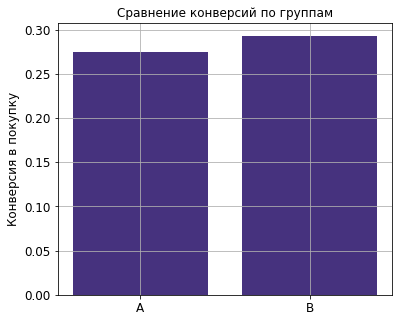

In [16]:
# Строим график
groups = ['A', 'B']
conversion_rates = [grp_a_p / grp_a, grp_b_p / grp_b]

plt.figure(figsize=(6, 5))
bars = plt.bar(groups, conversion_rates)
plt.ylabel('Конверсия в покупку')
plt.title('Сравнение конверсий по группам')
plt.grid(True)
plt.show()

In [17]:
print(f"""
Конверсия пользователей в покупатели в группе А: {round(conversion_rates[0],3)}
Конверсия пользователей в покупатели в группе В: {round(conversion_rates[1],3)}
""")


Конверсия пользователей в покупатели в группе А: 0.275
Конверсия пользователей в покупатели в группе В: 0.293



- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

**Предварительный общий вывод:**

После внедрения нового дизайна сайта наблюдается учеличение конверсии пользователей в покупатели в тестовой группе по сравнению с контрольной группой.
- Конверсия в группе А примерно 0.275
- Конверсия в группе В примерно 0.293

Таким образом, конверсия в тестовой группе выросла примерно на 1.8 процентных пункта, что может указывать на положительное влияние редизайна.

## 4. Проведите оценку результатов A/B-тестирования:

Сформилируем гипотезы:
- Н0 (нулевая гипотеза): конверсия в группе В не выше, чем в группе А
- Н1 (альтернативная): конверсия в группе В выше, чем в группе А

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

In [18]:
# Проведем Z тест для двух пропорций
counts = [grp_a_p, grp_b_p] 
nobs = [grp_a, grp_b]

z_stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative='smaller')

alpha = 0.05

print('p-value:', p_value)

if p_value > alpha:
    print('Нулевая гипотеза не отвергается.')
else:
    print('Принимаем альтернативную гипотезу')

p-value: 0.020012845303069515
Принимаем альтернативную гипотезу


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

**Вывод по результатам А/В тестирования**

Была проверена гипотеза о том, что редизайн сайт повышает конверсию пользователей в покупателей в течение первых 7  дней после регистрации. Выборка составила 5383 и 5467 человек в группах А и В соответственно. 

Согласно результатам:
- Конверсия в группе А (контрольная): 27,5%
- Конверсия в группе В (тестовая): 29,3%
- Разница составляет 1,8 процентных пункта, что отличается от числа, заявленного в техническом задании - 3%
- Р-значение: 0.02
 
При уровне значимости 0.05 результат статистически значим. Это означает, что вероятность случайно получить такую разницу при равных конверсиях менее 1%.

Нулевая гипотеза отвергнута, и мы принимаем альтернативную: **редизайн сайт действительно привел к росту конверсии**. Однако, рост конверсии хоть и статистически значим, все равно не достиг значений, указанных в изначальной гипотезе о росте конверсии в 3%.